### Import Package

In [1]:
# Import packages
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import osmnx as ox
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import datetime
from datetime import datetime, timedelta
from shapely.geometry import Point, shape, LineString
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from keras.models import Sequential
from keras.layers import Dense
import xgboost as xgb
import math
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, MinMaxScaler, StandardScaler
import libpysal as ps
from spreg import GM_Lag
from sklearn.linear_model import LassoCV
import statsmodels.api as sm
import os
from zipfile import ZipFile
import random
import networkx as nx
import warnings
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import VarianceThreshold
from scipy.optimize import minimize
from collections import Counter
import statsmodels.api as sm
import time
import shap

- Aggregated station group prediction 
- Single station level prediction
- Single station level prediction with station type classification (GMM based on GA or usage similarity)
- how to model spatial relationships between stations (based on GA, LU, and others, or self-learning and try to understand the learning results based on what)

### Final Data Form

#### station info

In [2]:
# read station info with poi distance
station_info = pd.read_csv('Data/station_att_info_poi_svi.csv')
station_info['geometry'] = station_info[['longitude', 'latitude']].values.tolist()
station_info['geometry'] = station_info['geometry'].apply(Point)

# rename columns
vq_column_list = ['road', 'sidewalk', 'building', 'wall', 'fence', 'pole',
       'traffic light', 'traffic sign', 'vegetation', 'terrain', 'sky',
       'person', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle',
       'bicycle']
vq_column_pct_list = ['SVI_pct_road', 'SVI_pct_sidewalk',
       'SVI_pct_building', 'SVI_pct_wall', 'SVI_pct_fence', 'SVI_pct_pole',
       'SVI_pct_traffic_light', 'SVI_pct_traffic_sign', 'SVI_pct_vegetation',
       'SVI_pct_terrain', 'SVI_pct_sky', 'SVI_pct_person', 'SVI_pct_rider',
       'SVI_pct_car', 'SVI_pct_truck', 'SVI_pct_bus', 'SVI_pct_train',
       'SVI_pct_motorcycle', 'SVI_pct_bicycle']

poi_column_list = ['school', 'bar', 'bench',
       'fast_food', 'restaurant', 'bank', 'parking', 'cafe', 'waste_basket',
       'place_of_worship']
poi_column_dist_list = ['dist_school', 'dist_bar', 'dist_bench',
       'dist_fast_food', 'dist_restaurant', 'dist_bank', 'dist_parking',
       'dist_cafe', 'dist_waste_basket', 'dist_place_of_worship']

for i in range (len(vq_column_list)):
    station_info = station_info.rename(columns = {vq_column_list[i]: vq_column_pct_list[i]})
for i in range (len(poi_column_list)):
    station_info = station_info.rename(columns = {poi_column_list[i]: poi_column_dist_list[i]})

# add poi num
station_info.head()

,station_id,latitude,longitude,GEOID,pop_den,median_age,white_ratio,male_ratio,housing_unit_den,LU_diversity,...,education_num_buff250,cultural_num_buff250,recreational_num_buff250,social_num_buff250,transportation_num_buff250,commercial_num_buff250,government_num_buff250,religion_num_buff250,health_num_buff250,publicsafety_num_buff250
0,31100.0,38.900289,-77.042902,11001010700,7.203283,31.3,0.835539,0.456207,6.704001,1.410208,...,3.0,2.0,35.0,20.0,37.0,40.0,1.0,2.0,4.0,0.0
1,31101.0,38.917766,-77.032083,11001004300,71.347523,34.6,0.806614,0.445004,46.145930,2.515274,...,4.0,0.0,18.0,3.0,26.0,36.0,1.0,2.0,2.0,0.0
2,31102.0,38.929463,-77.027821,11001003000,74.506295,31.3,0.351470,0.529397,34.313626,1.914395,...,1.0,2.0,3.0,1.0,10.0,3.0,0.0,2.0,0.0,0.0
3,31104.0,38.922865,-77.042517,11001003901,88.570549,38.1,0.630961,0.369417,66.411150,2.041013,...,2.0,0.0,13.0,1.0,30.0,50.0,0.0,2.0,4.0,1.0
4,31105.0,38.926792,-77.032203,11001003000,74.506295,31.3,0.351470,0.529397,34.313626,1.914395,...,6.0,0.0,1.0,11.0,36.0,6.0,0.0,1.0,3.0,0.0


In [3]:
station_info.columns

Index(['station_id', 'latitude', 'longitude', 'GEOID', 'pop_den', 'median_age',
       'white_ratio', 'male_ratio', 'housing_unit_den', 'LU_diversity',
       'bike_density', 'geometry', 'Bike_Stop', 'dist_school', 'dist_bar',
       'dist_bench', 'dist_fast_food', 'dist_restaurant', 'dist_bank',
       'dist_parking', 'dist_cafe', 'dist_waste_basket',
       'dist_place_of_worship', 'SVI_pct_road', 'SVI_pct_sidewalk',
       'SVI_pct_building', 'SVI_pct_wall', 'SVI_pct_fence', 'SVI_pct_pole',
       'SVI_pct_traffic_light', 'SVI_pct_traffic_sign', 'SVI_pct_vegetation',
       'SVI_pct_terrain', 'SVI_pct_sky', 'SVI_pct_person', 'SVI_pct_rider',
       'SVI_pct_car', 'SVI_pct_truck', 'SVI_pct_bus', 'SVI_pct_train',
       'SVI_pct_motorcycle', 'SVI_pct_bicycle', 'other_num_buff250',
       'residential_num_buff250', 'education_num_buff250',
       'cultural_num_buff250', 'recreational_num_buff250',
       'social_num_buff250', 'transportation_num_buff250',
       'commercial_num_buff250

#### ridership data

In [4]:
bike_data_attr_df = pd.read_csv("Data/bike_data_attr_df_final.csv")
bike_data_attr_df = bike_data_attr_df.drop(columns = {'station_id', 'latitude', 'longitude', 'GEOID', 'geometry'}, axis = 1)
bike_data_attr_df.head()

,metro_dnum_buff100,bus_dnum_buff100,metro_snum_buff100,bus_snum_buff100,degree,ridership,pagerank,betweenness,metro_dnum_buff50,bus_dnum_buff50,...,dist_school,dist_bar,dist_bench,dist_fast_food,dist_restaurant,dist_bank,dist_parking,dist_cafe,dist_waste_basket,dist_place_of_worship
0,0.0,0.0,0.0,3.0,0.016393,1.0,0.009620,0.00000,0,0,...,298.014670,250.755774,65.545098,196.861902,167.196625,168.988389,172.563974,186.788974,120.533169,213.217963
1,0.0,0.0,0.0,3.0,0.016393,2.0,0.017797,0.00082,0,0,...,181.033930,126.100317,162.191231,145.561811,194.600077,109.068886,176.384065,113.698382,193.075265,180.231956
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0,0,...,3.063937,105.171759,473.530310,398.580903,216.957319,391.311224,154.811090,366.140255,212.230060,231.714669
3,0.0,0.0,0.0,4.0,0.000000,2.0,0.018661,0.00000,0,0,...,115.117028,124.758377,568.654252,135.965274,130.333636,74.852788,152.255146,103.930870,538.503658,114.225692
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0,0,...,145.862413,246.955320,442.122423,201.192153,239.094483,251.498709,152.975660,233.506179,172.206643,215.066698


In [5]:
bike_data_attr_df.columns

Index(['metro_dnum_buff100', 'bus_dnum_buff100', 'metro_snum_buff100',
       'bus_snum_buff100', 'degree', 'ridership', 'pagerank', 'betweenness',
       'metro_dnum_buff50', 'bus_dnum_buff50', 'metro_snum_buff50',
       'bus_snum_buff50', 'metro_dnum_buff150', 'bus_dnum_buff150',
       'metro_snum_buff150', 'bus_snum_buff150', 'metro_dnum_buff200',
       'bus_dnum_buff200', 'metro_snum_buff200', 'bus_snum_buff200',
       'metro_dnum_buff250', 'bus_dnum_buff250', 'metro_snum_buff250',
       'bus_snum_buff250', 'Temp', 'Dew_Point', 'Humidity', 'WD', 'WS',
       'Pressure', 'Precipitation', 'other_num_buff250',
       'residential_num_buff250', 'education_num_buff250',
       'cultural_num_buff250', 'recreational_num_buff250',
       'social_num_buff250', 'transportation_num_buff250',
       'commercial_num_buff250', 'government_num_buff250',
       'religion_num_buff250', 'health_num_buff250',
       'publicsafety_num_buff250', 'SVI_pct_road', 'SVI_pct_sidewalk',
       'SVI_pct_

### Example of all variables for regression models
- Bike station: bike_data_attr_df & station_info (352 bike stations, data order: 352-352-352, for each hour, over the entire year)
- Bike centroid: centroid_data_attr_df & K_centroids_info (100 bike centroids: data order: 100-100-100, for each hour, over the entire year)

### Variable selection

In [6]:
var_list = ['ridership', 'metro_dnum_buff100', 'metro_snum_buff100',
 'bus_snum_buff100', 'betweenness', 'bus_dnum_buff50', 'metro_snum_buff50',
 'bus_snum_buff50', 'metro_dnum_buff150', 'bus_dnum_buff150',
  'metro_dnum_buff200',
 'metro_dnum_buff250', 'metro_snum_buff250',
 'bus_snum_buff250', 'Temp', 'WD', 'WS',
 'other_num_buff250', 'residential_num_buff250', 'education_num_buff250',
 'cultural_num_buff250', 'recreational_num_buff250', 'social_num_buff250',
 'transportation_num_buff250', 'commercial_num_buff250',
 'government_num_buff250', 'religion_num_buff250', 'health_num_buff250',
 'publicsafety_num_buff250',  'SVI_pct_sidewalk',
 'SVI_pct_building', 'SVI_pct_wall', 'SVI_pct_fence', 'SVI_pct_pole',
 'SVI_pct_traffic_light', 'SVI_pct_traffic_sign', 
 'SVI_pct_terrain', 'SVI_pct_sky', 'SVI_pct_person', 'SVI_pct_rider',
 'SVI_pct_car', 'SVI_pct_truck', 'SVI_pct_bus', 'SVI_pct_train',
 'SVI_pct_motorcycle', 'SVI_pct_bicycle', 'pop_den', 
 'bike_density', 'dist_school', 'dist_bar', 'dist_bench', 'dist_fast_food',
 'dist_restaurant', 'dist_bank', 'dist_cafe',
 'dist_waste_basket', 'dist_place_of_worship']

time_lag_list = [24,168,48,1,120,144,96,23]

bike_data_attr_df = bike_data_attr_df[var_list]
bike_data_attr_df.head()

,ridership,metro_dnum_buff100,metro_snum_buff100,bus_snum_buff100,betweenness,bus_dnum_buff50,metro_snum_buff50,bus_snum_buff50,metro_dnum_buff150,bus_dnum_buff150,...,bike_density,dist_school,dist_bar,dist_bench,dist_fast_food,dist_restaurant,dist_bank,dist_cafe,dist_waste_basket,dist_place_of_worship
0,1.0,0.0,0.0,3.0,0.00000,0,0,0,0,0,...,17.361177,298.014670,250.755774,65.545098,196.861902,167.196625,168.988389,186.788974,120.533169,213.217963
1,2.0,0.0,0.0,3.0,0.00082,0,0,1,0,0,...,21.194388,181.033930,126.100317,162.191231,145.561811,194.600077,109.068886,113.698382,193.075265,180.231956
2,0.0,0.0,0.0,0.0,0.00000,0,0,0,0,0,...,11.618369,3.063937,105.171759,473.530310,398.580903,216.957319,391.311224,366.140255,212.230060,231.714669
3,2.0,0.0,0.0,4.0,0.00000,0,0,1,0,0,...,15.024366,115.117028,124.758377,568.654252,135.965274,130.333636,74.852788,103.930870,538.503658,114.225692
4,0.0,0.0,0.0,0.0,0.00000,0,0,0,0,0,...,12.920176,145.862413,246.955320,442.122423,201.192153,239.094483,251.498709,233.506179,172.206643,215.066698


### Final Data Preparation for Model

In [7]:
# add time-lagged ridership & betweenness data
time_order = 168
bike_data_lag_df = pd.DataFrame({'ridership': bike_data_attr_df['ridership'].iloc[time_order*len(station_info):365*24*len(station_info)].array})
for i in time_lag_list:
    bike_data_lag_df['ridership_lag' + str(i)] = bike_data_attr_df['ridership'].iloc[(time_order-i)*len(station_info):(365*24-i)*len(station_info)].array
    bike_data_lag_df['betweenness_lag' + str(i)] = bike_data_attr_df['betweenness'].iloc[(time_order-i)*len(station_info):(365*24-i)*len(station_info)].array
bike_data_lag_df = bike_data_lag_df.drop(columns = 'ridership', axis = 1)
bike_data_lag_df.head()

,ridership_lag24,betweenness_lag24,ridership_lag168,betweenness_lag168,ridership_lag48,betweenness_lag48,ridership_lag1,betweenness_lag1,ridership_lag120,betweenness_lag120,ridership_lag144,betweenness_lag144,ridership_lag96,betweenness_lag96,ridership_lag23,betweenness_lag23
0,0.0,0.0,1.0,0.00000,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,2.0,0.00082,3.0,0.002801,0.0,0.0,1.0,0.0,0.0,0.000000,2.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.00000,0.0,0.003641,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,2.0,0.00000,0.0,0.000840,0.0,0.0,0.0,0.0,1.0,0.001976,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [8]:
# final dataset for predicting ridership
bike_data_attr_df = bike_data_attr_df.iloc[time_order*len(station_info):365*24*len(station_info)].reset_index(drop=True)
bike_data_attr_df = pd.concat([bike_data_attr_df, bike_data_lag_df], axis = 1)
bike_data_attr_df.head()

,ridership,metro_dnum_buff100,metro_snum_buff100,bus_snum_buff100,betweenness,bus_dnum_buff50,metro_snum_buff50,bus_snum_buff50,metro_dnum_buff150,bus_dnum_buff150,...,ridership_lag1,betweenness_lag1,ridership_lag120,betweenness_lag120,ridership_lag144,betweenness_lag144,ridership_lag96,betweenness_lag96,ridership_lag23,betweenness_lag23
0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.000000,2.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,4.0,0.0,41,0,1,0,155,...,0.0,0.0,0.0,0.0,1.0,0.001976,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [9]:
bike_data_attr_df.columns

Index(['ridership', 'metro_dnum_buff100', 'metro_snum_buff100',
       'bus_snum_buff100', 'betweenness', 'bus_dnum_buff50',
       'metro_snum_buff50', 'bus_snum_buff50', 'metro_dnum_buff150',
       'bus_dnum_buff150', 'metro_dnum_buff200', 'metro_dnum_buff250',
       'metro_snum_buff250', 'bus_snum_buff250', 'Temp', 'WD', 'WS',
       'other_num_buff250', 'residential_num_buff250', 'education_num_buff250',
       'cultural_num_buff250', 'recreational_num_buff250',
       'social_num_buff250', 'transportation_num_buff250',
       'commercial_num_buff250', 'government_num_buff250',
       'religion_num_buff250', 'health_num_buff250',
       'publicsafety_num_buff250', 'SVI_pct_sidewalk', 'SVI_pct_building',
       'SVI_pct_wall', 'SVI_pct_fence', 'SVI_pct_pole',
       'SVI_pct_traffic_light', 'SVI_pct_traffic_sign', 'SVI_pct_terrain',
       'SVI_pct_sky', 'SVI_pct_person', 'SVI_pct_rider', 'SVI_pct_car',
       'SVI_pct_truck', 'SVI_pct_bus', 'SVI_pct_train', 'SVI_pct_motorcycle',


### Adjacency Matrix

In [10]:
bike_ridership_arr = bike_data_attr_df['ridership'].values.reshape((int(len(bike_data_attr_df)/len(station_info)), len(station_info)))
bike_ridership_arr.shape

(8592, 352)

#### Geographic adjacency matrix

In [11]:
# geographical adjacency matrix based on physical proximity (352*352)
station_geometry = gpd.GeoDataFrame({'geometry': station_info['geometry']}, crs='EPSG:4326').to_crs('EPSG:5234')
bike_gw_station = np.zeros((len(station_info), len(station_info)))
for i in range (len(station_info)):
    for j in range (i+1, len(station_info)):
        bike_gw_station[i,j] = 1000/station_geometry.iloc[i][0].distance(station_geometry.iloc[j][0]) #1/(dist/1000)
bike_gw_station = bike_gw_station + bike_gw_station.T # 352*352

bike_gw_station = normalize(bike_gw_station, norm='l1')
bike_data_attr_df['GA_ridership'] = np.dot(bike_ridership_arr, bike_gw_station).flatten()
bike_data_attr_df.head()

,ridership,metro_dnum_buff100,metro_snum_buff100,bus_snum_buff100,betweenness,bus_dnum_buff50,metro_snum_buff50,bus_snum_buff50,metro_dnum_buff150,bus_dnum_buff150,...,betweenness_lag1,ridership_lag120,betweenness_lag120,ridership_lag144,betweenness_lag144,ridership_lag96,betweenness_lag96,ridership_lag23,betweenness_lag23,GA_ridership
0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.065951
1,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,...,0.0,1.0,0.0,0.0,0.000000,2.0,0.0,0.0,0.0,0.069417
2,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.038389
3,1.0,0.0,0.0,4.0,0.0,41,0,1,0,155,...,0.0,0.0,0.0,1.0,0.001976,1.0,0.0,0.0,0.0,0.044153
4,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.045340


#### Demographics and built environment similarity

In [12]:
# demographic and built environment similarity matrix (352*352)
bike_dbs_station = np.zeros((len(station_info), len(station_info)))
dbs_list = ['pop_den', 'median_age', 'white_ratio', 'male_ratio', 'housing_unit_den', 'LU_diversity', 'bike_density']
station_info_similarity = station_info[dbs_list].values
scaler = MinMaxScaler()
station_info_similarity = scaler.fit_transform(station_info_similarity)
for i in range (len(station_info_similarity)):
    for j in range (i+1, len(station_info_similarity)):
        vector1 = station_info_similarity[i,:]
        vector2 = station_info_similarity[j,:]
        bike_dbs_station[i,j] = np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))
bike_dbs_station = bike_dbs_station + bike_dbs_station.T # 352*352

bike_dbs_station = normalize(bike_dbs_station, norm='l1')
bike_data_attr_df['DBS_ridership'] = np.dot(bike_ridership_arr, bike_dbs_station).flatten()
bike_data_attr_df.head()

,ridership,metro_dnum_buff100,metro_snum_buff100,bus_snum_buff100,betweenness,bus_dnum_buff50,metro_snum_buff50,bus_snum_buff50,metro_dnum_buff150,bus_dnum_buff150,...,ridership_lag120,betweenness_lag120,ridership_lag144,betweenness_lag144,ridership_lag96,betweenness_lag96,ridership_lag23,betweenness_lag23,GA_ridership,DBS_ridership
0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.065951,0.040884
1,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,...,1.0,0.0,0.0,0.000000,2.0,0.0,0.0,0.0,0.069417,0.042882
2,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.038389,0.041454
3,1.0,0.0,0.0,4.0,0.0,41,0,1,0,155,...,0.0,0.0,1.0,0.001976,1.0,0.0,0.0,0.0,0.044153,0.037380
4,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.045340,0.041520


#### SVIs and POI similarity

In [13]:
# SVIs and POI similarity matrix (352*352)
bike_spoi_station = np.zeros((len(station_info), len(station_info)))
spoi_list = [
 'other_num_buff250', 'residential_num_buff250', 'education_num_buff250',
 'cultural_num_buff250', 'recreational_num_buff250', 'social_num_buff250',
 'transportation_num_buff250', 'commercial_num_buff250',
 'government_num_buff250', 'religion_num_buff250', 'health_num_buff250',
 'publicsafety_num_buff250',  'SVI_pct_sidewalk',
 'SVI_pct_building', 'SVI_pct_wall', 'SVI_pct_fence', 'SVI_pct_pole',
 'SVI_pct_traffic_light', 'SVI_pct_traffic_sign', 
 'SVI_pct_terrain', 'SVI_pct_sky', 'SVI_pct_person', 'SVI_pct_rider',
 'SVI_pct_car', 'SVI_pct_truck', 'SVI_pct_bus', 'SVI_pct_train',
 'SVI_pct_motorcycle', 'SVI_pct_bicycle', 'dist_school', 'dist_bar', 'dist_bench', 'dist_fast_food',
 'dist_restaurant', 'dist_bank', 'dist_cafe',
 'dist_waste_basket', 'dist_place_of_worship']
station_info_similarity = station_info[spoi_list].values
scaler = MinMaxScaler()
station_info_similarity = scaler.fit_transform(station_info_similarity)
for i in range (len(station_info_similarity)):
    for j in range (i+1, len(station_info_similarity)):
        vector1 = station_info_similarity[i,:]
        vector2 = station_info_similarity[j,:]
        bike_spoi_station[i,j] = np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))
bike_spoi_station = bike_spoi_station + bike_spoi_station.T # 352*352

bike_spoi_station = normalize(bike_spoi_station, norm='l1')
bike_data_attr_df['SPOI_ridership'] = np.dot(bike_ridership_arr, bike_spoi_station).flatten()
bike_data_attr_df.head()

,ridership,metro_dnum_buff100,metro_snum_buff100,bus_snum_buff100,betweenness,bus_dnum_buff50,metro_snum_buff50,bus_snum_buff50,metro_dnum_buff150,bus_dnum_buff150,...,betweenness_lag120,ridership_lag144,betweenness_lag144,ridership_lag96,betweenness_lag96,ridership_lag23,betweenness_lag23,GA_ridership,DBS_ridership,SPOI_ridership
0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.065951,0.040884,0.051888
1,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,...,0.0,0.0,0.000000,2.0,0.0,0.0,0.0,0.069417,0.042882,0.048562
2,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.038389,0.041454,0.038090
3,1.0,0.0,0.0,4.0,0.0,41,0,1,0,155,...,0.0,1.0,0.001976,1.0,0.0,0.0,0.0,0.044153,0.037380,0.044441
4,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.045340,0.041520,0.044011


## Prediction Models: Data Preparation

### All Features

### Three Models over All dataset

In [14]:
total_var_list = ['metro_dnum_buff100', 'metro_snum_buff100',
       'bus_snum_buff100', 'betweenness', 'bus_dnum_buff50',
       'metro_snum_buff50', 'bus_snum_buff50', 'metro_dnum_buff150',
       'bus_dnum_buff150', 'metro_dnum_buff200', 'metro_dnum_buff250',
       'metro_snum_buff250', 'bus_snum_buff250', 'Temp', 'WD', 'WS',
       'other_num_buff250', 'residential_num_buff250', 'education_num_buff250',
       'cultural_num_buff250', 'recreational_num_buff250',
       'social_num_buff250', 'transportation_num_buff250',
       'commercial_num_buff250', 'government_num_buff250',
       'religion_num_buff250', 'health_num_buff250',
       'publicsafety_num_buff250', 'SVI_pct_sidewalk', 'SVI_pct_building',
       'SVI_pct_wall', 'SVI_pct_fence', 'SVI_pct_pole',
       'SVI_pct_traffic_light', 'SVI_pct_traffic_sign', 'SVI_pct_terrain',
       'SVI_pct_sky', 'SVI_pct_person', 'SVI_pct_rider', 'SVI_pct_car',
       'SVI_pct_truck', 'SVI_pct_bus', 'SVI_pct_train', 'SVI_pct_motorcycle',
       'SVI_pct_bicycle', 'pop_den', 'bike_density', 'dist_school', 'dist_bar',
       'dist_bench', 'dist_fast_food', 'dist_restaurant', 'dist_bank',
       'dist_cafe', 'dist_waste_basket', 'dist_place_of_worship',
       'ridership_lag24', 'betweenness_lag24', 'ridership_lag168',
       'betweenness_lag168', 'ridership_lag48', 'betweenness_lag48',
       'ridership_lag1', 'betweenness_lag1', 'ridership_lag120',
       'betweenness_lag120', 'ridership_lag144', 'betweenness_lag144',
       'ridership_lag96', 'betweenness_lag96', 'ridership_lag23',
       'betweenness_lag23', 'GA_ridership', 'DBS_ridership', 'SPOI_ridership']

in_var_list = ['ridership_lag24', 'ridership_lag168', 'ridership_lag48', 'ridership_lag1', 
               'ridership_lag120', 'ridership_lag144', 'ridership_lag96', 'ridership_lag23',
               'Temp', 'WD', 'WS', 'GA_ridership', 'DBS_ridership', 'SPOI_ridership', 'pop_den', 'bike_density',
               'betweenness', 'betweenness_lag24', 'betweenness_lag168', 'betweenness_lag48', 'betweenness_lag1',
               'betweenness_lag120', 'betweenness_lag144', 'betweenness_lag96', 'betweenness_lag23',
               'dist_school', 'dist_bar', 'dist_bench', 'dist_fast_food', 'dist_restaurant', 'dist_bank',
               'dist_cafe', 'dist_waste_basket', 'dist_place_of_worship',
               'other_num_buff250', 'residential_num_buff250', 'education_num_buff250', 'cultural_num_buff250', 
               'recreational_num_buff250', 'social_num_buff250', 'transportation_num_buff250', 'commercial_num_buff250', 
               'government_num_buff250', 'religion_num_buff250', 'health_num_buff250', 'publicsafety_num_buff250',
               'metro_dnum_buff100', 'metro_snum_buff100', 'bus_snum_buff100', 'bus_dnum_buff50',
               'metro_snum_buff50', 'bus_snum_buff50', 'metro_dnum_buff150', 'bus_dnum_buff150', 
               'metro_dnum_buff200', 'metro_dnum_buff250', 'metro_snum_buff250', 'bus_snum_buff250',
               'SVI_pct_sidewalk', 'SVI_pct_building', 'SVI_pct_wall', 'SVI_pct_fence', 'SVI_pct_pole',
               'SVI_pct_traffic_light', 'SVI_pct_traffic_sign', 'SVI_pct_terrain', 'SVI_pct_sky', 'SVI_pct_person', 
               'SVI_pct_rider', 'SVI_pct_car', 'SVI_pct_truck', 'SVI_pct_bus', 'SVI_pct_train', 'SVI_pct_motorcycle', 'SVI_pct_bicycle']

y = bike_data_attr_df['ridership'].values
print(len(y))
X = bike_data_attr_df[in_var_list].values

random.seed(45)

all_xgb_train_mse_station = []
all_xgb_test_mse_station = []
all_xgb_train_r2_station = []
all_xgb_test_r2_station = []

### training and testing performance
hour_len = int(len(bike_data_attr_df)/len(station_info))
train_index_list = random.sample(range(hour_len), int(0.8*hour_len))
test_index_list = [element for element in range(hour_len) if element not in train_index_list]
train_index_list_f = np.array([np.arange(element*352, (element+1)*352) for element in train_index_list]).flatten()
test_index_list_f = np.array([np.arange(element*352, (element+1)*352) for element in test_index_list]).flatten()
X_train_allhour = X[train_index_list_f]
y_train_allhour = y[train_index_list_f]
X_test_allhour = X[test_index_list_f]
y_test_allhour = y[test_index_list_f]

#X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.2)
## XGBoost models
allhour_model = xgb.XGBRegressor(objective='reg:squarederror', max_depth = 9, gamma = 0.1, reg_lambda = 1, n_estimators=1000, learning_rate=0.006, subsample = 0.6)
eval_set = [(X_train_allhour, y_train_allhour), (X_test_allhour, y_test_allhour)]
allhour_model.fit(X_train_allhour, y_train_allhour, eval_metric=["rmse", "mae"], eval_set=eval_set, early_stopping_rounds=10, verbose = False)
y_train_pred_allhour = allhour_model.predict(X_train_allhour)
y_test_pred_allhour = allhour_model.predict(X_test_allhour)
print('XGBoost:')
mse_train_allhour = mean_squared_error(y_train_allhour, y_train_pred_allhour)
mse_test_allhour = mean_squared_error(y_test_allhour, y_test_pred_allhour)
print("Training MSE:", mse_train_allhour)
print("Testing MSE:", mse_test_allhour)
r2_train_allhour = r2_score(y_train_allhour, y_train_pred_allhour)
r2_test_allhour = r2_score(y_test_allhour, y_test_pred_allhour)
print("Training r^2:", r2_train_allhour)
print("Testing r^2:", r2_test_allhour)
# station-level predictive performance
for iiiii in range(len(station_info)):
    station_train_list = np.arange(len(train_index_list)) * len(station_info) + iiiii
    station_test_list = np.arange(len(test_index_list)) * len(station_info) + iiiii
    all_xgb_train_mse_station.append(mean_squared_error(y_train_allhour[station_train_list], y_train_pred_allhour[station_train_list]))
    all_xgb_test_mse_station.append(mean_squared_error(y_test_allhour[station_test_list], y_test_pred_allhour[station_test_list]))
    all_xgb_train_r2_station.append(r2_score(y_train_allhour[station_train_list], y_train_pred_allhour[station_train_list]))
    all_xgb_test_r2_station.append(r2_score(y_test_allhour[station_test_list], y_test_pred_allhour[station_test_list]))
print('='*50)
print("")

3024384


D:\Software\Anaconda\Install\envs\gpd_env\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
D:\Software\Anaconda\Install\envs\gpd_env\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBoost:
Training MSE: 1.3403203097978553
Testing MSE: 1.5447758570541392
Training r^2: 0.7097488831011531
Testing r^2: 0.6736867898026582



#### Total Average Over All Stations

In [15]:
all_xgb_train_mse_station = np.array(all_xgb_train_mse_station)
all_xgb_test_mse_station = np.array(all_xgb_test_mse_station)
all_xgb_train_r2_station = np.array(all_xgb_train_r2_station)
all_xgb_test_r2_station = np.array(all_xgb_test_r2_station)

In [16]:
print('ALL-HOUR DATASET:')
print('='*100)

print('XGB:')
print('='*50)
print('Training MSE:', all_xgb_train_mse_station)
print('Testing MSE:', all_xgb_test_mse_station)
print('Training r2:', all_xgb_train_r2_station)
print('Testing r2:', all_xgb_test_r2_station)

ALL-HOUR DATASET:
XGB:
Training MSE: [1.01655980e+00 4.05904536e+00 1.89787690e+00 2.66704340e+00
 1.12876175e+00 7.21394582e-01 2.20651179e+00 3.14748582e+00
 2.39435247e+00 2.64951450e+00 1.81943847e+00 6.43262625e-01
 1.81573770e+00 2.98856648e+00 1.35005409e+00 2.13229679e+00
 2.19192843e+00 1.11877344e+00 2.13056623e+00 1.21147988e+00
 1.47585873e+00 1.23622250e+00 1.02228841e+00 5.28482053e+00
 2.79400798e+00 2.54726275e+00 1.29308856e+00 2.76535127e+00
 4.78449777e+00 6.14707381e-01 3.80697814e-01 6.39414502e-05
 3.66913195e-05 1.56329008e-05 1.13726219e-04 4.61457316e-05
 2.63161690e-06 1.77800447e-05 4.66205460e+00 5.07707035e+00
 2.79283932e+00 3.65263805e+00 1.39958307e+00 1.99856480e+00
 4.65235370e-01 5.13457476e-01 1.20305019e+00 3.64223628e+00
 1.19189255e+00 2.42662490e+00 2.57626532e+00 3.38346644e+00
 2.16541629e+00 1.98470287e+00 1.96142655e+00 2.64989031e+00
 3.25163020e+00 9.39781968e-01 2.30375764e+00 2.71567435e+00
 2.73730191e+00 1.12009801e+00 1.52550566e+00 5.

#### SHAP

##### SHAP Plots for All features

100%|===================| 605079/605088 [791:54<00:00]         

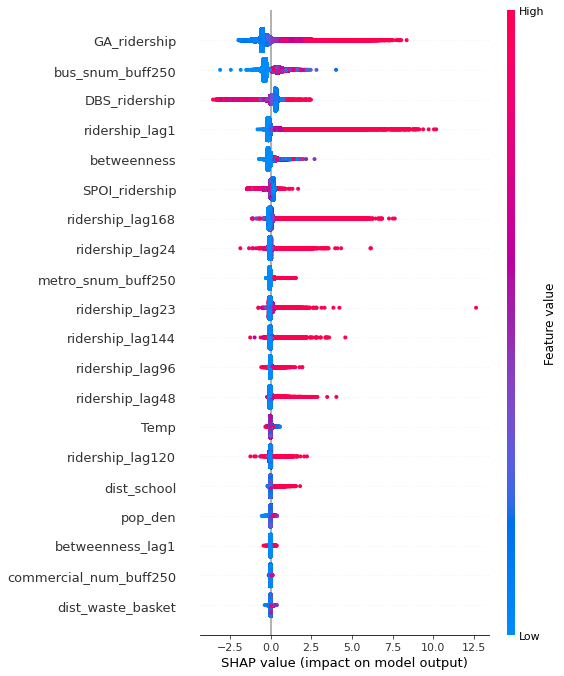

In [17]:
## calculate SHAP Values
# Initialize the SHAP explainer
allhour_explainer = shap.Explainer(allhour_model, X_train_allhour)

# Calculate SHAP values for the test set
allhour_shap_values = allhour_explainer.shap_values(X_test_allhour)

# Summary plot
shap.summary_plot(allhour_shap_values, X_test_allhour, plot_type="dot", feature_names=in_var_list)

##### SHAP Features for SVIs and PT

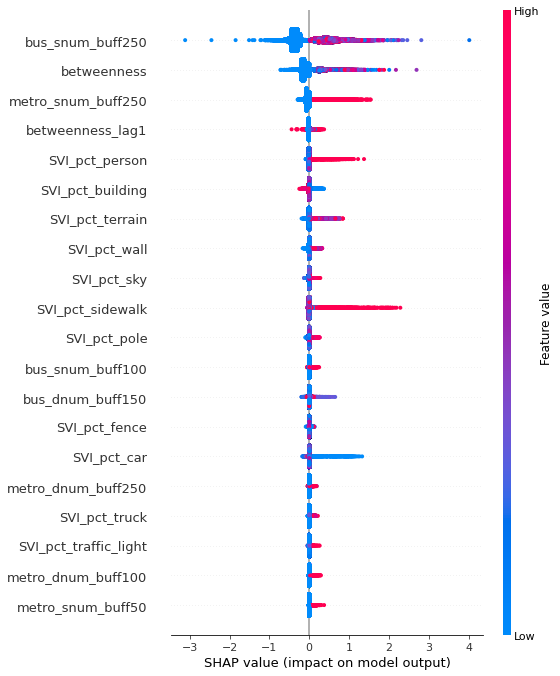

In [18]:
index_list_SVI_PT = np.array([16, 20] + list(np.arange(46, len(in_var_list))))
SVI_PT_var_list = ['betweenness', 'betweenness_lag1',
               'metro_dnum_buff100', 'metro_snum_buff100', 'bus_snum_buff100', 'bus_dnum_buff50',
               'metro_snum_buff50', 'bus_snum_buff50', 'metro_dnum_buff150', 'bus_dnum_buff150', 
               'metro_dnum_buff200', 'metro_dnum_buff250', 'metro_snum_buff250', 'bus_snum_buff250',
               'SVI_pct_sidewalk', 'SVI_pct_building', 'SVI_pct_wall', 'SVI_pct_fence', 'SVI_pct_pole',
               'SVI_pct_traffic_light', 'SVI_pct_traffic_sign', 'SVI_pct_terrain', 'SVI_pct_sky', 'SVI_pct_person', 
               'SVI_pct_rider', 'SVI_pct_car', 'SVI_pct_truck', 'SVI_pct_bus', 'SVI_pct_train', 'SVI_pct_motorcycle', 'SVI_pct_bicycle']
shap.summary_plot(allhour_shap_values[:, index_list_SVI_PT], X_test_allhour[:, index_list_SVI_PT], plot_type="dot", feature_names=SVI_PT_var_list)

##### SHAP Features for SVIS

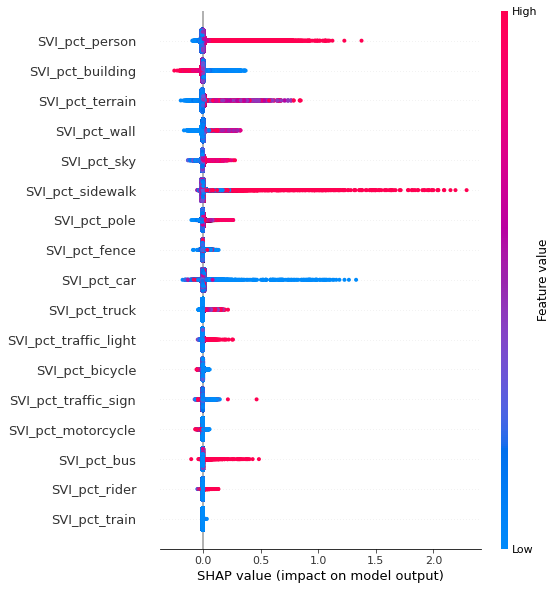

In [19]:
index_list_SVI = np.arange(58, len(in_var_list))
SVI_var_list = ['SVI_pct_sidewalk', 'SVI_pct_building', 'SVI_pct_wall', 'SVI_pct_fence', 'SVI_pct_pole',
               'SVI_pct_traffic_light', 'SVI_pct_traffic_sign', 'SVI_pct_terrain', 'SVI_pct_sky', 'SVI_pct_person', 
               'SVI_pct_rider', 'SVI_pct_car', 'SVI_pct_truck', 'SVI_pct_bus', 'SVI_pct_train', 'SVI_pct_motorcycle', 'SVI_pct_bicycle']
shap.summary_plot(allhour_shap_values[:, index_list_SVI], X_test_allhour[:, index_list_SVI], plot_type="dot", feature_names=SVI_var_list)

##### SHAP Features for PT

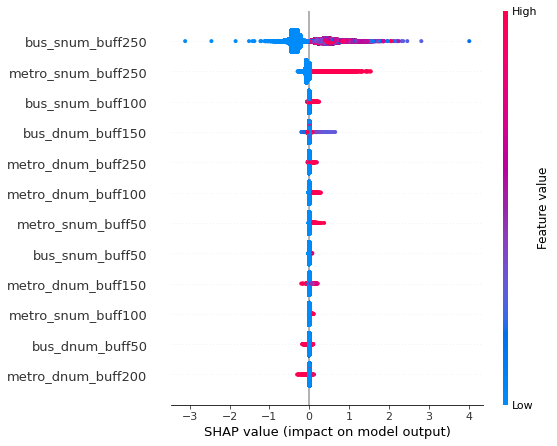

In [20]:
index_list_PT = np.arange(46, 58)
PT_var_list = ['metro_dnum_buff100', 'metro_snum_buff100', 'bus_snum_buff100', 'bus_dnum_buff50',
               'metro_snum_buff50', 'bus_snum_buff50', 'metro_dnum_buff150', 'bus_dnum_buff150', 
               'metro_dnum_buff200', 'metro_dnum_buff250', 'metro_snum_buff250', 'bus_snum_buff250']
shap.summary_plot(allhour_shap_values[:, index_list_PT], X_test_allhour[:, index_list_PT], plot_type="dot", feature_names=PT_var_list)

##### Dependence Plots

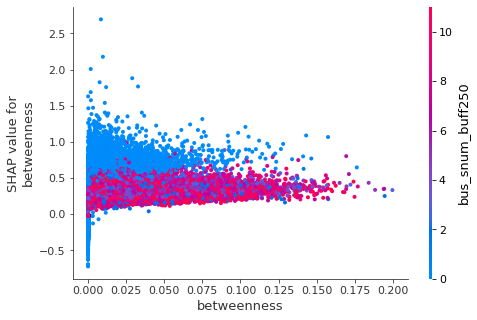

In [21]:
# Dependence plot for the feature "RM" (average number of rooms per dwelling)
shap.dependence_plot("betweenness", allhour_shap_values, X_test_allhour, feature_names=in_var_list)

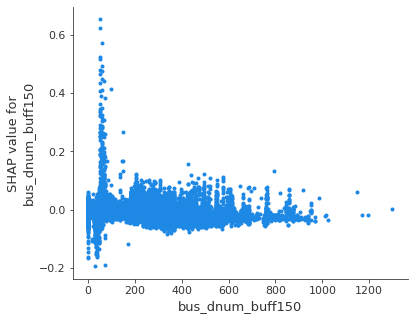

In [56]:
# Dependence plot for the feature "RM" (average number of rooms per dwelling)
shap.dependence_plot("bus_dnum_buff150", allhour_shap_values, X_test_allhour, feature_names=in_var_list, interaction_index = None)

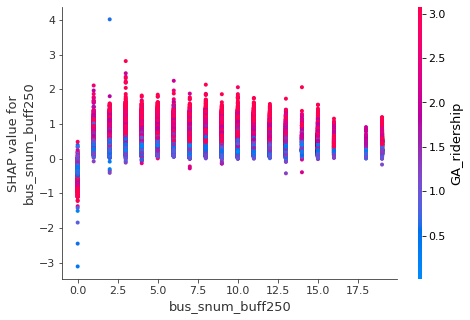

In [22]:
# Dependence plot for the feature "RM" (average number of rooms per dwelling)
shap.dependence_plot("bus_snum_buff250", allhour_shap_values, X_test_allhour, feature_names=in_var_list)

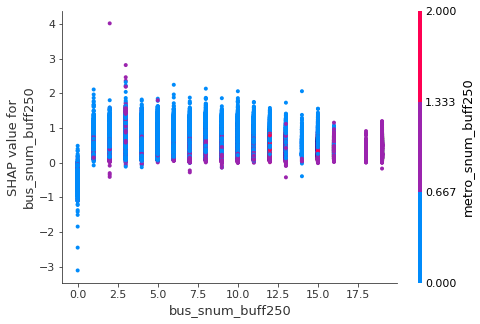

In [23]:
# Dependence plot for the feature "RM" (average number of rooms per dwelling)
shap.dependence_plot("bus_snum_buff250", allhour_shap_values[:, index_list_PT], X_test_allhour[:, index_list_PT], feature_names=PT_var_list)

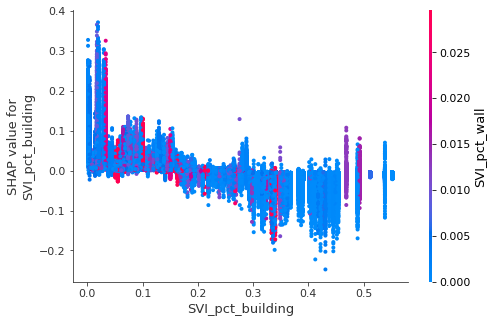

In [24]:
# Dependence plot for the feature "RM" (average number of rooms per dwelling)
shap.dependence_plot("SVI_pct_building", allhour_shap_values[:, index_list_SVI], X_test_allhour[:, index_list_SVI], feature_names=SVI_var_list)

### Three Models over Non-Zero Dataset

In [25]:
# baseline model

index_nonzero = np.where(bike_data_attr_df['ridership'].array > 0)[0]

in_var_list = ['ridership_lag24', 'ridership_lag168', 'ridership_lag48', 'ridership_lag1', 
               'ridership_lag120', 'ridership_lag144', 'ridership_lag96', 'ridership_lag23',
               'Temp', 'WD', 'WS', 'GA_ridership', 'DBS_ridership', 'SPOI_ridership', 'pop_den', 'bike_density',
               'betweenness', 'betweenness_lag24', 'betweenness_lag168', 'betweenness_lag48', 'betweenness_lag1',
               'betweenness_lag120', 'betweenness_lag144', 'betweenness_lag96', 'betweenness_lag23',
               'dist_school', 'dist_bar', 'dist_bench', 'dist_fast_food', 'dist_restaurant', 'dist_bank',
               'dist_cafe', 'dist_waste_basket', 'dist_place_of_worship',
               'other_num_buff250', 'residential_num_buff250', 'education_num_buff250', 'cultural_num_buff250', 
               'recreational_num_buff250', 'social_num_buff250', 'transportation_num_buff250', 'commercial_num_buff250', 
               'government_num_buff250', 'religion_num_buff250', 'health_num_buff250', 'publicsafety_num_buff250',
               'metro_dnum_buff100', 'metro_snum_buff100', 'bus_snum_buff100', 'bus_dnum_buff50',
               'metro_snum_buff50', 'bus_snum_buff50', 'metro_dnum_buff150', 'bus_dnum_buff150', 
               'metro_dnum_buff200', 'metro_dnum_buff250', 'metro_snum_buff250', 'bus_snum_buff250',
               'SVI_pct_sidewalk', 'SVI_pct_building', 'SVI_pct_wall', 'SVI_pct_fence', 'SVI_pct_pole',
               'SVI_pct_traffic_light', 'SVI_pct_traffic_sign', 'SVI_pct_terrain', 'SVI_pct_sky', 'SVI_pct_person', 
               'SVI_pct_rider', 'SVI_pct_car', 'SVI_pct_truck', 'SVI_pct_bus', 'SVI_pct_train', 'SVI_pct_motorcycle', 'SVI_pct_bicycle']

y = bike_data_attr_df['ridership'].values # .iloc[index_nonzero]
print(len(y))
X = bike_data_attr_df[in_var_list].values # .iloc[index_nonzero, :]

random.seed(46)

# 5-FOLD CROSS VALIDATION

nonzero_xgb_train_mse_station = []
nonzero_xgb_test_mse_station = []
nonzero_xgb_train_r2_station = []
nonzero_xgb_test_r2_station = []

### training and testing performance
station_index = index_nonzero % len(station_info)
train_index_list_station = []
test_index_list_station = []
train_index_list = []
test_index_list = []
for jjj in range(len(station_info)):
    station_jjj_index = index_nonzero[np.where(station_index == jjj)[0]]
    train_jjj_index_list = random.sample(range(len(station_jjj_index)), int(0.8*len(station_jjj_index)))
    test_jjj_index_list = [element for element in range(len(station_jjj_index)) if element not in train_jjj_index_list]
    train_index_list_station.append(station_jjj_index[train_jjj_index_list])
    test_index_list_station.append(station_jjj_index[test_jjj_index_list])
    train_index_list = train_index_list + list(station_jjj_index[train_jjj_index_list])
    test_index_list = test_index_list + list(station_jjj_index[test_jjj_index_list])

X_train_nonzero = X[train_index_list]
y_train_nonzero = y[train_index_list]
X_test_nonzero = X[test_index_list]
y_test_nonzero = y[test_index_list]

#X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.2)

## XGBoost models
nonzero_model = xgb.XGBRegressor(objective='reg:squarederror', max_depth = 9, gamma = 0.1, reg_lambda = 1, n_estimators=1000, learning_rate=0.006, subsample = 0.6)
eval_set = [(X_train_nonzero, y_train_nonzero), (X_test_nonzero, y_test_nonzero)]
nonzero_model.fit(X_train_nonzero, y_train_nonzero, eval_metric=["rmse", "mae"], eval_set=eval_set, early_stopping_rounds=10, verbose = False)
y_train_pred_nonzero = nonzero_model.predict(X_train_nonzero)
y_test_pred_nonzero = nonzero_model.predict(X_test_nonzero)
y_pred_nonzero = nonzero_model.predict(X)
print('XGBoost:')
mse_train_nonzero = mean_squared_error(y_train_nonzero, y_train_pred_nonzero)
mse_test_nonzero = mean_squared_error(y_test_nonzero, y_test_pred_nonzero)
print("Training MSE:", mse_train_nonzero)
print("Testing MSE:", mse_test_nonzero)
r2_train_nonzero = r2_score(y_train_nonzero, y_train_pred_nonzero)
r2_test_nonzero = r2_score(y_test_nonzero, y_test_pred_nonzero)
print("Training r^2:", r2_train_nonzero)
print("Testing r^2:", r2_test_nonzero)
# station-level predictive performance
for iiiii in range(len(station_info)):
    if len(train_index_list_station[iiiii]) > 0:
        nonzero_xgb_train_mse_station.append(mean_squared_error(y[train_index_list_station[iiiii]], y_pred_nonzero[train_index_list_station[iiiii]]))
        nonzero_xgb_test_mse_station.append(mean_squared_error(y[test_index_list_station[iiiii]], y_pred_nonzero[test_index_list_station[iiiii]]))
        nonzero_xgb_train_r2_station.append(r2_score(y[train_index_list_station[iiiii]], y_pred_nonzero[train_index_list_station[iiiii]]))
        nonzero_xgb_test_r2_station.append(r2_score(y[test_index_list_station[iiiii]], y_pred_nonzero[test_index_list_station[iiiii]]))
    else:
        nonzero_xgb_train_mse_station.append(np.nan)
        nonzero_xgb_test_mse_station.append(np.nan)
        nonzero_xgb_train_r2_station.append(np.nan)
        nonzero_xgb_test_r2_station.append(np.nan)
print('='*50)
print("")

3024384


D:\Software\Anaconda\Install\envs\gpd_env\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
D:\Software\Anaconda\Install\envs\gpd_env\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBoost:
Training MSE: 3.786935251936392
Testing MSE: 4.122741943556498
Training r^2: 0.5628065755998615
Testing r^2: 0.5217177716591224



D:\Software\Anaconda\Install\envs\gpd_env\lib\site-packages\sklearn\metrics\_regression.py:781: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
D:\Software\Anaconda\Install\envs\gpd_env\lib\site-packages\sklearn\metrics\_regression.py:781: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
D:\Software\Anaconda\Install\envs\gpd_env\lib\site-packages\sklearn\metrics\_regression.py:781: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


#### MSE Over All Stations

In [26]:
nonzero_xgb_train_mse_station = np.array(nonzero_xgb_train_mse_station)
nonzero_xgb_test_mse_station = np.array(nonzero_xgb_test_mse_station)
nonzero_xgb_train_r2_station = np.array(nonzero_xgb_train_r2_station)
nonzero_xgb_test_r2_station = np.array(nonzero_xgb_test_r2_station)

In [27]:
print('NONE-ZERO DATASET:')
print('='*100)

print('XGB:')
print('='*50)
print('Training MSE:', nonzero_xgb_train_mse_station)
print('Testing MSE:', nonzero_xgb_test_mse_station)
print('Training r2:', nonzero_xgb_train_r2_station)
print('Testing r2:', nonzero_xgb_test_r2_station)

NONE-ZERO DATASET:
XGB:
Training MSE: [2.46856232e+00 6.22469167e+00 3.31995698e+00 3.37309715e+00
 2.01564931e+00 1.66377041e+00 3.43816554e+00 5.15886224e+00
 3.21818342e+00 3.83685691e+00 2.46557334e+00 1.65459897e+00
 2.54052019e+00 4.12821600e+00 2.04114921e+00 3.23117933e+00
 3.11246099e+00 1.91188234e+00 3.05061409e+00 1.90562307e+00
 2.19188140e+00 1.96919971e+00 2.00726633e+00 8.63317213e+00
 4.35408007e+00 3.99197581e+00 2.32175093e+00 3.88776064e+00
 8.94119667e+00 2.38794868e+00 1.51762897e+00            nan
            nan            nan            nan            nan
            nan            nan 7.26501871e+00 7.84481755e+00
 3.56719710e+00 4.70275195e+00 2.55107730e+00 3.75030523e+00
 1.62933056e+00 1.00571777e+00 2.17180877e+00 1.41832660e+01
 2.31078285e+00 3.45076655e+00 4.52641126e+00 4.64469169e+00
 4.18464915e+00 4.04380491e+00 4.68712266e+00 5.20284459e+00
 8.53814701e+00 2.54247360e+00 4.15492915e+00 5.39471656e+00
 4.09383975e+00 2.22132836e+00 2.66261235e+00 8

#### SHAP

##### SHAP Plots for All features

100%|===================| 194955/194970 [134:36<00:00]        

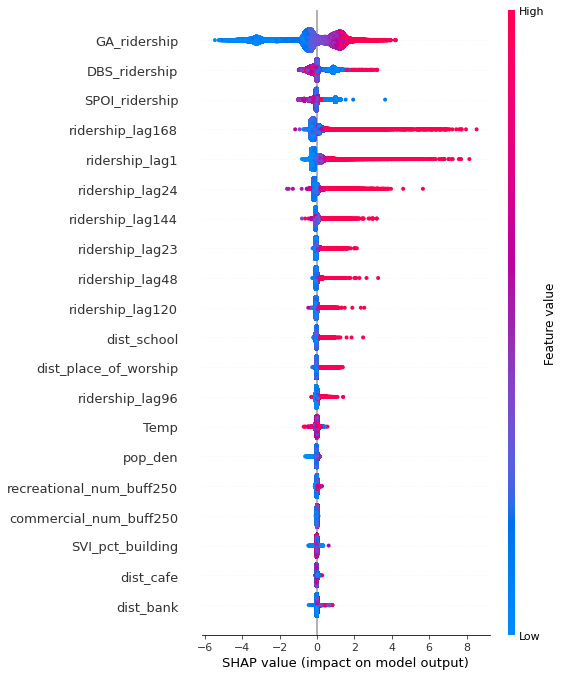

In [28]:
## calculate SHAP Values
# Initialize the SHAP explainer
nonzero_explainer = shap.Explainer(nonzero_model, X_train_nonzero)

# Calculate SHAP values for the test set
nonzero_shap_values = nonzero_explainer.shap_values(X_test_nonzero)

# Summary plot
shap.summary_plot(nonzero_shap_values, X_test_nonzero, plot_type="dot", feature_names=in_var_list)

##### SHAP Features for SVIs and PT

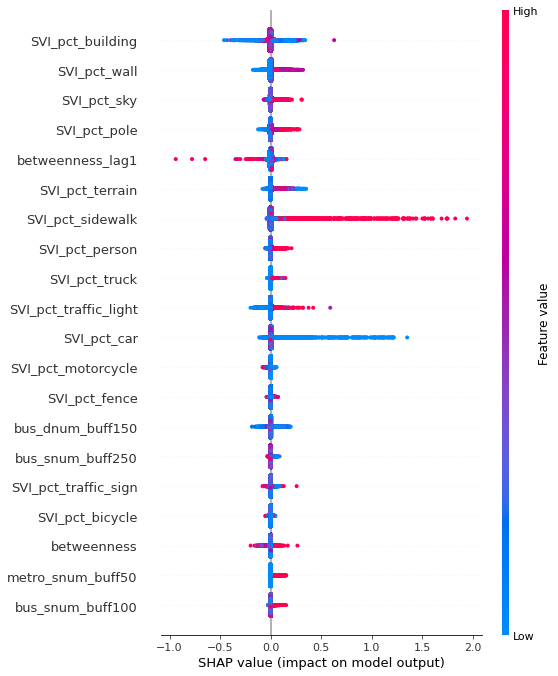

In [29]:
index_list_SVI_PT = np.array([16, 20] + list(np.arange(46, len(in_var_list))))
SVI_PT_var_list = ['betweenness', 'betweenness_lag1',
               'metro_dnum_buff100', 'metro_snum_buff100', 'bus_snum_buff100', 'bus_dnum_buff50',
               'metro_snum_buff50', 'bus_snum_buff50', 'metro_dnum_buff150', 'bus_dnum_buff150', 
               'metro_dnum_buff200', 'metro_dnum_buff250', 'metro_snum_buff250', 'bus_snum_buff250',
               'SVI_pct_sidewalk', 'SVI_pct_building', 'SVI_pct_wall', 'SVI_pct_fence', 'SVI_pct_pole',
               'SVI_pct_traffic_light', 'SVI_pct_traffic_sign', 'SVI_pct_terrain', 'SVI_pct_sky', 'SVI_pct_person', 
               'SVI_pct_rider', 'SVI_pct_car', 'SVI_pct_truck', 'SVI_pct_bus', 'SVI_pct_train', 'SVI_pct_motorcycle', 'SVI_pct_bicycle']
shap.summary_plot(nonzero_shap_values[:, index_list_SVI_PT], X_test_nonzero[:, index_list_SVI_PT], plot_type="dot", feature_names=SVI_PT_var_list)

##### SHAP Features for SVIS

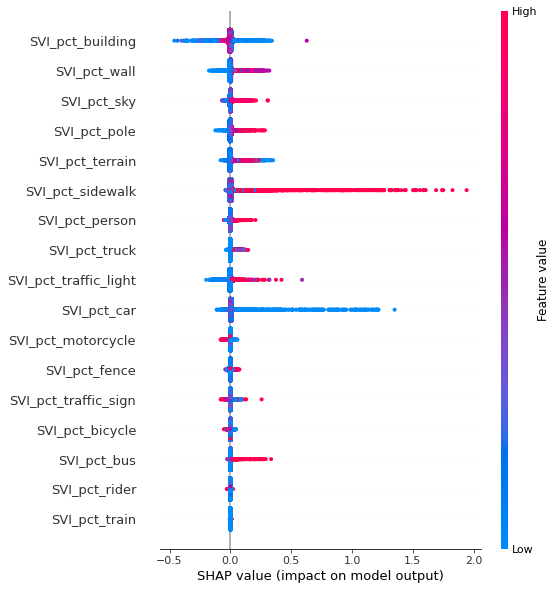

In [30]:
index_list_SVI = np.arange(58, len(in_var_list))
SVI_var_list = ['SVI_pct_sidewalk', 'SVI_pct_building', 'SVI_pct_wall', 'SVI_pct_fence', 'SVI_pct_pole',
               'SVI_pct_traffic_light', 'SVI_pct_traffic_sign', 'SVI_pct_terrain', 'SVI_pct_sky', 'SVI_pct_person', 
               'SVI_pct_rider', 'SVI_pct_car', 'SVI_pct_truck', 'SVI_pct_bus', 'SVI_pct_train', 'SVI_pct_motorcycle', 'SVI_pct_bicycle']
shap.summary_plot(nonzero_shap_values[:, index_list_SVI], X_test_nonzero[:, index_list_SVI], plot_type="dot", feature_names=SVI_var_list)

##### SHAP Features for PT

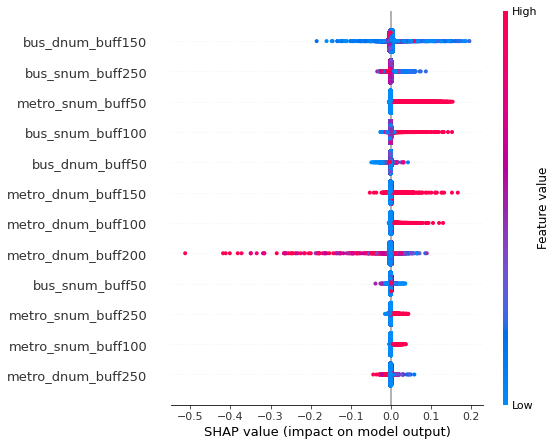

In [31]:
index_list_PT = np.arange(46, 58)
PT_var_list = ['metro_dnum_buff100', 'metro_snum_buff100', 'bus_snum_buff100', 'bus_dnum_buff50',
               'metro_snum_buff50', 'bus_snum_buff50', 'metro_dnum_buff150', 'bus_dnum_buff150', 
               'metro_dnum_buff200', 'metro_dnum_buff250', 'metro_snum_buff250', 'bus_snum_buff250']
shap.summary_plot(nonzero_shap_values[:, index_list_PT], X_test_nonzero[:, index_list_PT], plot_type="dot", feature_names=PT_var_list)

##### Dependence Plots

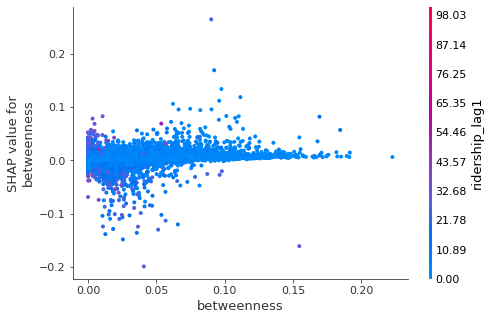

In [32]:
# Dependence plot for the feature "RM" (average number of rooms per dwelling)
shap.dependence_plot("betweenness", nonzero_shap_values, X_test_nonzero, feature_names=in_var_list)

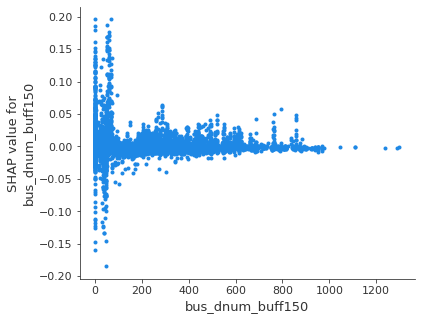

In [53]:
# Dependence plot for the feature "RM" (average number of rooms per dwelling)
shap.dependence_plot("bus_dnum_buff150", nonzero_shap_values, X_test_nonzero, feature_names=in_var_list, interaction_index = None)

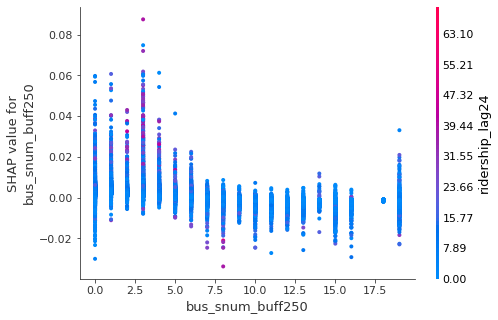

In [33]:
# Dependence plot for the feature "RM" (average number of rooms per dwelling)
shap.dependence_plot("bus_snum_buff250", nonzero_shap_values, X_test_nonzero, feature_names=in_var_list)

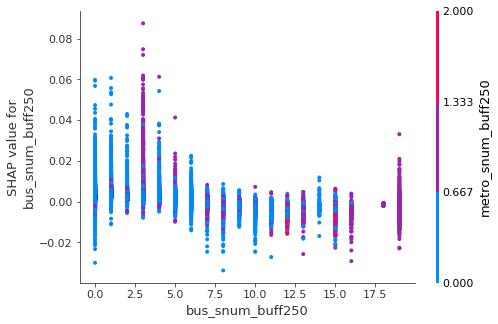

In [34]:
# Dependence plot for the feature "RM" (average number of rooms per dwelling)
shap.dependence_plot("bus_snum_buff250", nonzero_shap_values[:, index_list_PT], X_test_nonzero[:, index_list_PT], feature_names=PT_var_list)

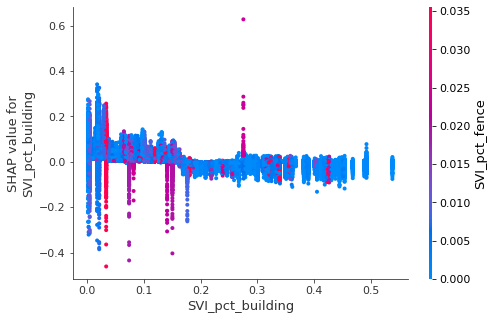

In [35]:
# Dependence plot for the feature "RM" (average number of rooms per dwelling)
shap.dependence_plot("SVI_pct_building", nonzero_shap_values[:, index_list_SVI], X_test_nonzero[:, index_list_SVI], feature_names=SVI_var_list)

### Three Models over Rush-Hour Dataset

In [36]:
# select those data in the mornning and evening rush hours
# 7-10 am and 4-8 pm
index_hour = []
for i in range (365-int(time_order/24)): # 24days
    index_hour.append(np.array([7,8,9,16,17,18,19]) + 24*i)
index_hour = np.array(index_hour).flatten()
index_rush = []
for i in index_hour:
    index_rush.append(np.arange(i*len(station_info), (i+1)*len(station_info)))
index_rush = np.array(index_rush).flatten()

in_var_list = ['ridership_lag24', 'ridership_lag168', 'ridership_lag48', 'ridership_lag1', 
               'ridership_lag120', 'ridership_lag144', 'ridership_lag96', 'ridership_lag23',
               'Temp', 'WD', 'WS', 'GA_ridership', 'DBS_ridership', 'SPOI_ridership', 'pop_den', 'bike_density',
               'betweenness', 'betweenness_lag24', 'betweenness_lag168', 'betweenness_lag48', 'betweenness_lag1',
               'betweenness_lag120', 'betweenness_lag144', 'betweenness_lag96', 'betweenness_lag23',
               'dist_school', 'dist_bar', 'dist_bench', 'dist_fast_food', 'dist_restaurant', 'dist_bank',
               'dist_cafe', 'dist_waste_basket', 'dist_place_of_worship',
               'other_num_buff250', 'residential_num_buff250', 'education_num_buff250', 'cultural_num_buff250', 
               'recreational_num_buff250', 'social_num_buff250', 'transportation_num_buff250', 'commercial_num_buff250', 
               'government_num_buff250', 'religion_num_buff250', 'health_num_buff250', 'publicsafety_num_buff250',
               'metro_dnum_buff100', 'metro_snum_buff100', 'bus_snum_buff100', 'bus_dnum_buff50',
               'metro_snum_buff50', 'bus_snum_buff50', 'metro_dnum_buff150', 'bus_dnum_buff150', 
               'metro_dnum_buff200', 'metro_dnum_buff250', 'metro_snum_buff250', 'bus_snum_buff250',
               'SVI_pct_sidewalk', 'SVI_pct_building', 'SVI_pct_wall', 'SVI_pct_fence', 'SVI_pct_pole',
               'SVI_pct_traffic_light', 'SVI_pct_traffic_sign', 'SVI_pct_terrain', 'SVI_pct_sky', 'SVI_pct_person', 
               'SVI_pct_rider', 'SVI_pct_car', 'SVI_pct_truck', 'SVI_pct_bus', 'SVI_pct_train', 'SVI_pct_motorcycle', 'SVI_pct_bicycle']

y = bike_data_attr_df['ridership'].iloc[index_rush].values
print(len(y))
X = bike_data_attr_df[in_var_list].iloc[index_rush, :].values

random.seed(48)

# 5-FOLD CROSS VALIDATION

rushhour_xgb_train_mse_station = []
rushhour_xgb_test_mse_station = []
rushhour_xgb_train_r2_station = []
rushhour_xgb_test_r2_station = []

### training and testing performance
hour_len = int(len(bike_data_attr_df) * 7 / (len(station_info) * 24))
train_index_list = random.sample(range(hour_len), int(0.8*hour_len))
test_index_list = [element for element in range(hour_len) if element not in train_index_list]
train_index_list_f = np.array([np.arange(element*352, (element+1)*352) for element in train_index_list]).flatten()
test_index_list_f = np.array([np.arange(element*352, (element+1)*352) for element in test_index_list]).flatten()
X_train_rushhour = X[train_index_list_f]
y_train_rushhour = y[train_index_list_f]
X_test_rushhour = X[test_index_list_f]
y_test_rushhour = y[test_index_list_f]

#X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.2)

## XGBoost models
rushhour_model = xgb.XGBRegressor(objective='reg:squarederror', max_depth = 9, gamma = 0.1, reg_lambda = 1, n_estimators=1000, learning_rate=0.006, subsample = 0.6)
eval_set = [(X_train_rushhour, y_train_rushhour), (X_test_rushhour, y_test_rushhour)]
rushhour_model.fit(X_train_rushhour, y_train_rushhour, eval_metric=["rmse", "mae"], eval_set=eval_set, early_stopping_rounds=10, verbose = False)
y_train_pred_rushhour = rushhour_model.predict(X_train_rushhour)
y_test_pred_rushhour = rushhour_model.predict(X_test_rushhour)
print('XGBoost:')
mse_train_rushhour = mean_squared_error(y_train_rushhour, y_train_pred_rushhour)
mse_test_rushhour = mean_squared_error(y_test_rushhour, y_test_pred_rushhour)
print("Training MSE:", mse_train_rushhour)
print("Testing MSE:", mse_test_rushhour)
r2_train_rushhour = r2_score(y_train_rushhour, y_train_pred_rushhour)
r2_test_rushhour = r2_score(y_test_rushhour, y_test_pred_rushhour)
print("Training r^2:", r2_train_rushhour)
print("Testing r^2:", r2_test_rushhour)
# station-level predictive performance
for iiiii in range(len(station_info)):
    station_train_list = np.arange(len(train_index_list)) * len(station_info) + iiiii
    station_test_list = np.arange(len(test_index_list)) * len(station_info) + iiiii
    rushhour_xgb_train_mse_station.append(mean_squared_error(y_train_rushhour[station_train_list], y_train_pred_rushhour[station_train_list]))
    rushhour_xgb_test_mse_station.append(mean_squared_error(y_test_rushhour[station_test_list], y_test_pred_rushhour[station_test_list]))
    rushhour_xgb_train_r2_station.append(r2_score(y_train_rushhour[station_train_list], y_train_pred_rushhour[station_train_list]))
    rushhour_xgb_test_r2_station.append(r2_score(y_test_rushhour[station_test_list], y_test_pred_rushhour[station_test_list]))
print('='*50)
print("")

882112


D:\Software\Anaconda\Install\envs\gpd_env\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
D:\Software\Anaconda\Install\envs\gpd_env\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBoost:
Training MSE: 2.2101706888457113
Testing MSE: 2.6883440586211695
Training r^2: 0.7510738608570035
Testing r^2: 0.6949183088447002



#### MSE Over All Stations

In [37]:
rushhour_xgb_train_mse_station = np.array(rushhour_xgb_train_mse_station)
rushhour_xgb_test_mse_station = np.array(rushhour_xgb_test_mse_station)
rushhour_xgb_train_r2_station = np.array(rushhour_xgb_train_r2_station)
rushhour_xgb_test_r2_station = np.array(rushhour_xgb_test_r2_station)

In [38]:
print('RUSH-HOUR DATASET:')
print('='*100)

print('XGB:')
print('='*50)
print('Training MSE:', rushhour_xgb_train_mse_station)
print('Testing MSE:', rushhour_xgb_test_mse_station)
print('Training r2:', rushhour_xgb_train_r2_station)
print('Testing r2:', rushhour_xgb_test_r2_station)

RUSH-HOUR DATASET:
XGB:
Training MSE: [2.20529398e+00 6.67375904e+00 3.10742951e+00 4.24651650e+00
 2.31883443e+00 1.52651168e+00 4.13418363e+00 5.30239754e+00
 3.63439997e+00 4.95338766e+00 2.73333929e+00 8.54453398e-01
 3.21222305e+00 4.40886753e+00 2.49208532e+00 3.86119637e+00
 4.24368832e+00 2.28883050e+00 4.09438550e+00 2.44010053e+00
 3.11024802e+00 2.48978277e+00 2.30931603e+00 7.93579174e+00
 5.06510251e+00 4.69810429e+00 2.36522003e+00 4.66167688e+00
 6.48530498e+00 1.32556134e+00 7.32744035e-01 1.20157840e-04
 6.47776368e-05 5.32129208e-05 2.72315696e-04 6.49730957e-05
 2.30667200e-06 2.16323343e-05 7.43354570e+00 8.17452644e+00
 4.31309037e+00 5.84195475e+00 2.65528899e+00 3.74838584e+00
 9.03029113e-01 9.10741334e-01 1.86914966e+00 3.02068229e+00
 2.03588193e+00 4.46432892e+00 5.28378403e+00 5.88416565e+00
 3.55576681e+00 4.19886330e+00 3.22870780e+00 4.46953694e+00
 4.82831440e+00 2.05082666e+00 4.39233147e+00 4.61485290e+00
 5.11821090e+00 1.99995142e+00 2.18726787e+00 9

#### SHAP

##### SHAP Plots for All features

100%|===================| 176696/176704 [292:15<00:00]         

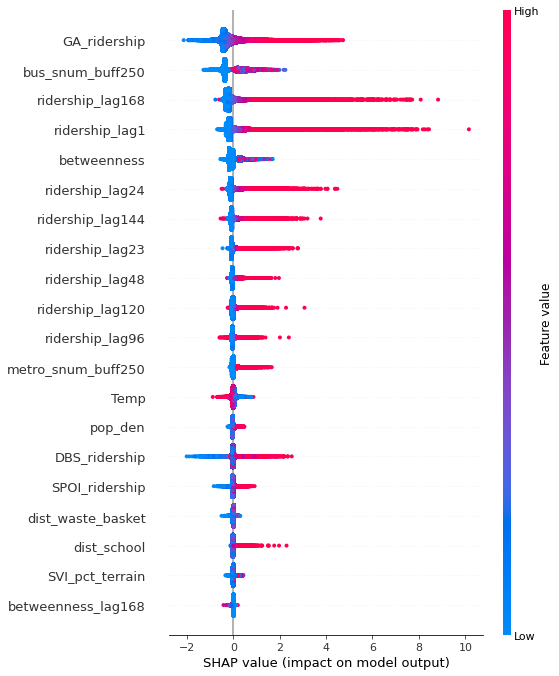

In [39]:
## calculate SHAP Values
# Initialize the SHAP explainer
rushhour_explainer = shap.Explainer(rushhour_model, X_train_rushhour)

# Calculate SHAP values for the test set
rushhour_shap_values = rushhour_explainer.shap_values(X_test_rushhour)

# Summary plot
shap.summary_plot(rushhour_shap_values, X_test_rushhour, plot_type="dot", feature_names=in_var_list)

##### SHAP Features for SVIs and PT

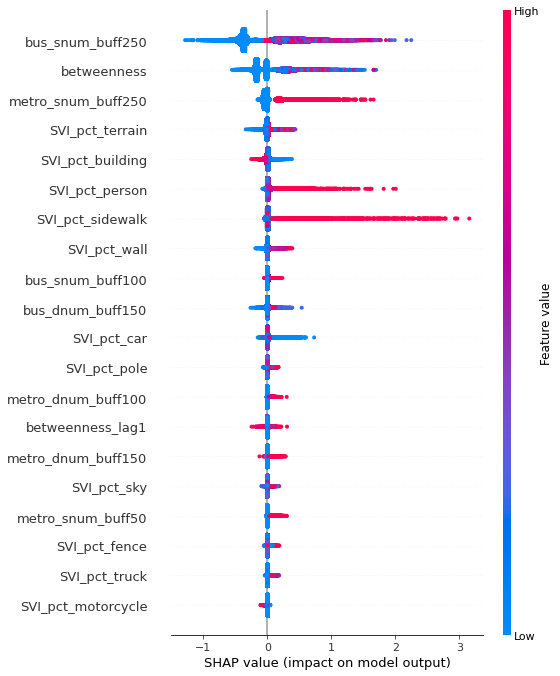

In [40]:
index_list_SVI_PT = np.array([16, 20] + list(np.arange(46, len(in_var_list))))
SVI_PT_var_list = ['betweenness', 'betweenness_lag1',
               'metro_dnum_buff100', 'metro_snum_buff100', 'bus_snum_buff100', 'bus_dnum_buff50',
               'metro_snum_buff50', 'bus_snum_buff50', 'metro_dnum_buff150', 'bus_dnum_buff150', 
               'metro_dnum_buff200', 'metro_dnum_buff250', 'metro_snum_buff250', 'bus_snum_buff250',
               'SVI_pct_sidewalk', 'SVI_pct_building', 'SVI_pct_wall', 'SVI_pct_fence', 'SVI_pct_pole',
               'SVI_pct_traffic_light', 'SVI_pct_traffic_sign', 'SVI_pct_terrain', 'SVI_pct_sky', 'SVI_pct_person', 
               'SVI_pct_rider', 'SVI_pct_car', 'SVI_pct_truck', 'SVI_pct_bus', 'SVI_pct_train', 'SVI_pct_motorcycle', 'SVI_pct_bicycle']
shap.summary_plot(rushhour_shap_values[:, index_list_SVI_PT], X_test_rushhour[:, index_list_SVI_PT], plot_type="dot", feature_names=SVI_PT_var_list)

##### SHAP Features for SVIS

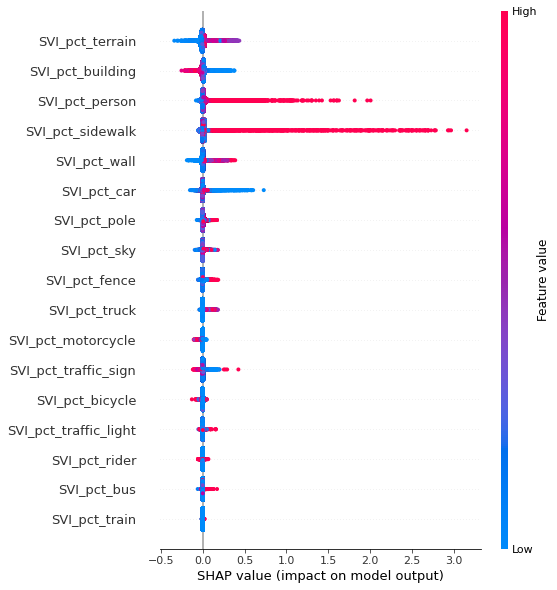

In [41]:
index_list_SVI = np.arange(58, len(in_var_list))
SVI_var_list = ['SVI_pct_sidewalk', 'SVI_pct_building', 'SVI_pct_wall', 'SVI_pct_fence', 'SVI_pct_pole',
               'SVI_pct_traffic_light', 'SVI_pct_traffic_sign', 'SVI_pct_terrain', 'SVI_pct_sky', 'SVI_pct_person', 
               'SVI_pct_rider', 'SVI_pct_car', 'SVI_pct_truck', 'SVI_pct_bus', 'SVI_pct_train', 'SVI_pct_motorcycle', 'SVI_pct_bicycle']
shap.summary_plot(rushhour_shap_values[:, index_list_SVI], X_test_rushhour[:, index_list_SVI], plot_type="dot", feature_names=SVI_var_list)

##### SHAP Features for PT

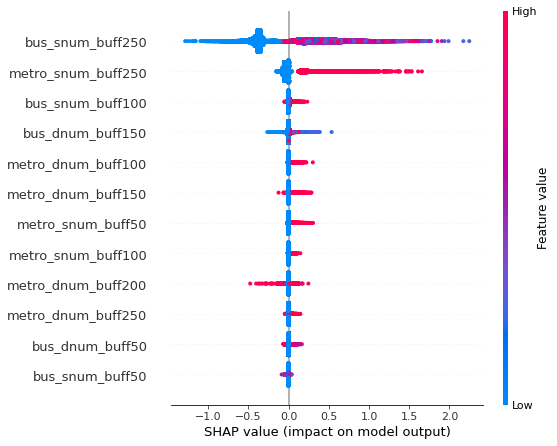

In [42]:
index_list_PT = np.arange(46, 58)
PT_var_list = ['metro_dnum_buff100', 'metro_snum_buff100', 'bus_snum_buff100', 'bus_dnum_buff50',
               'metro_snum_buff50', 'bus_snum_buff50', 'metro_dnum_buff150', 'bus_dnum_buff150', 
               'metro_dnum_buff200', 'metro_dnum_buff250', 'metro_snum_buff250', 'bus_snum_buff250']
shap.summary_plot(rushhour_shap_values[:, index_list_PT], X_test_rushhour[:, index_list_PT], plot_type="dot", feature_names=PT_var_list)

##### Dependence Plots

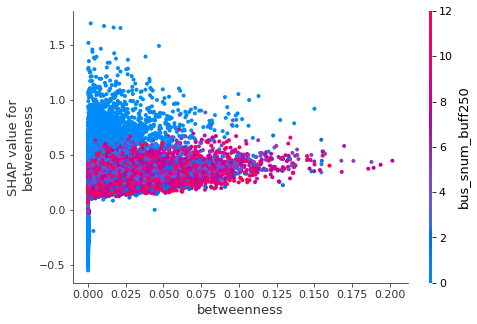

In [43]:
# Dependence plot for the feature "RM" (average number of rooms per dwelling)
shap.dependence_plot("betweenness", rushhour_shap_values, X_test_rushhour, feature_names=in_var_list)

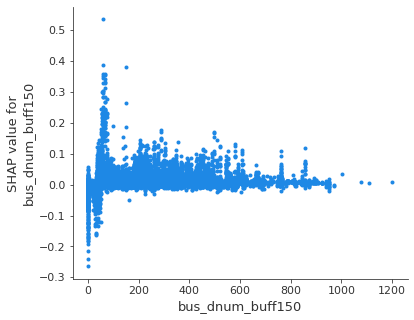

In [54]:
# Dependence plot for the feature "RM" (average number of rooms per dwelling)
shap.dependence_plot("bus_dnum_buff150", rushhour_shap_values, X_test_rushhour, feature_names=in_var_list, interaction_index = None)

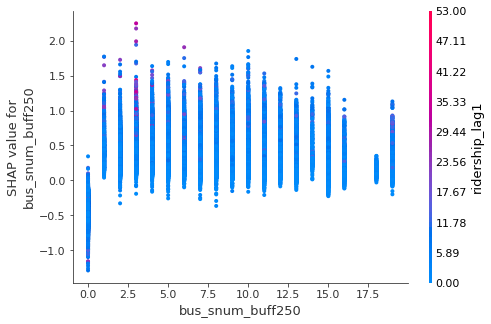

In [44]:
# Dependence plot for the feature "RM" (average number of rooms per dwelling)
shap.dependence_plot("bus_snum_buff250", rushhour_shap_values, X_test_rushhour, feature_names=in_var_list)

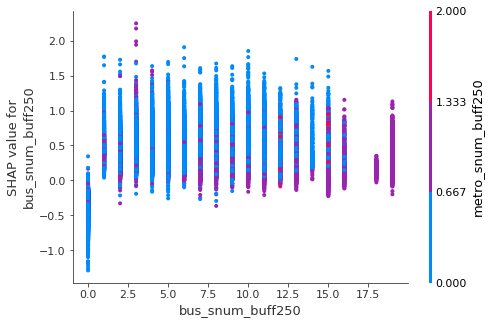

In [45]:
# Dependence plot for the feature "RM" (average number of rooms per dwelling)
shap.dependence_plot("bus_snum_buff250", rushhour_shap_values[:, index_list_PT], X_test_rushhour[:, index_list_PT], feature_names=PT_var_list)

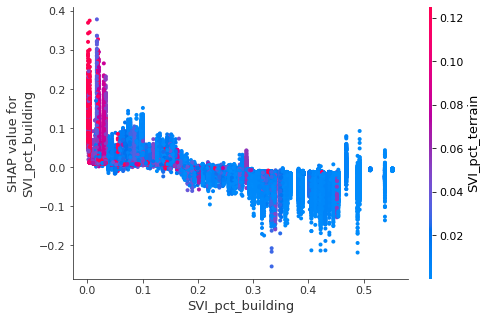

In [46]:
# Dependence plot for the feature "RM" (average number of rooms per dwelling)
shap.dependence_plot("SVI_pct_building", rushhour_shap_values[:, index_list_SVI], X_test_rushhour[:, index_list_SVI], feature_names=SVI_var_list)